<a href="https://colab.research.google.com/github/MGonzalez506/Dimensionamiento_PV/blob/18-generar-la-simulaci%C3%B3n-del-proyecto-en-pvsyst/Comparativa_PVLib_y_PVSyst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Comparativa de simulación entre PVLib y la herramienta PVSyst

### Instalando las librerías de pvlib y rdtools

In [1]:
!pip install pvlib
!pip install rdtools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 27.6 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 947 kB 4.4 MB/s 
     |████████████████████████████████| 192.9 MB 64 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


### Importar las librerías necesarias y algunos alias

In [18]:
#Imports
import sys
import os
import traceback
import time
import signal
import fcntl
import string
import re
import itertools

import math
import pytz
import pvlib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

from sklearn.metrics import mean_absolute_error

from time import sleep
from datetime import datetime
from io import StringIO
from pvlib import solarposition
from pvlib import pvsystem
from pvlib import location
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib import irradiance
from pvlib import temperature
from rdtools import get_clearsky_tamb

### Datos del lugar en estudio y glosario

In [3]:
site_tz='America/Costa_Rica'
site_lat = 9.84950
site_lon = -83.91289
site_name = 'Moren Centro de acondicionamiento Físico'
site_alt = 1360

coordinates = [
               (site_lat,site_lon,site_name,site_alt,site_tz)
]

glosario = {
      'sapm':'Sandia PV Array Performance Model',
      'sam':'System Advisor Model',
      'tmy':'Typical Meteorological Year Data',
      'ghi':'Radiación global Horizontal', 
      'dni':'Radiación directa', 
      'dhi':'Radiación difusa', 
      'IR(h)':'Índice de claridad', 
      'aoi':'Ángulo de incidencia', 
      'dni_extra':'Porcentaje de radiación extra',
      'POA':'Plane of Array'
      }

### Seleccionar dataFrames, dispositivos y modelos
- Seleccionando el DataFrame a utilizar en cuanto a modelos e inversores
- Seleccionando el módulo fotovoltaico a utilizar y el inversor correspondiente
- Seleccionando el modelo de la temperatura a utilizar
- Seleccionando la cantidad de módulos que se necesitan para lograr lleva el inversor a utilizar su máxima potencia (string_config)
- Creando las dos listas que almacenarán los datos de la data típica por año y los meses seleccionados por la librería para el estudio

In [46]:
#Get modules & inverters
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('CECInverter')

module = (sandia_modules['Canadian_Solar_CS5P_220M___2009_'])
#inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
inverter = sapm_inverters['PV_Powered__PVP1100']
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
string_config = 5

tmys = []
selected_months = []

### Generando una función que devuelve toda la data respecto a una ubicación u condiciones climatológicas específicas

In [50]:
def get_pvgis_tmy_from_coordinates(coordinates):
  tmys = []
  months = []
  for location in coordinates:
    latitude, longitude, name, altitude, timezone = location
    data_frame = pvlib.iotools.get_pvgis_tmy(latitude,longitude,map_variables=True)
    weather = data_frame[0]
    weather.index.name = 'utc_time'
    tmys.append(weather)
    months = data_frame[1]
  return tmys, months
tmys,selected_months = get_pvgis_tmy_from_coordinates(coordinates)

### Iteración sobre todos los ángulos de Azimuth seleccionados y ángulos de inclinación seleccionados también.

In [51]:
#Para realizar el cálculo del ángulo de inclinación óptima
system = {'module':module, 'inversor':inverter, 'surface_azimuth':180}
azimuth_testing = [0, 90,180,270]
tilt_testing = [5,10,15]
energies = {}
selected_azimuth_angle = 180
selected_tilt_angle = 10
selected_data = pd.DataFrame()
selected_data_annual_energy = {}
for tilt_angle in tilt_testing:
  for azimuth_angle in azimuth_testing:
    for weather in tmys:
        location = coordinates[0]
        latitude, longitude, name, altitude, timezone = location
        system['surface_tilt']=tilt_angle
        system['surface_azimuth']=azimuth_angle
        solpos = pvlib.solarposition.get_solarposition(
            time=weather.index,
            latitude=latitude,
            longitude=longitude,
            altitude=altitude,
            temperature=weather['temp_air'],
            pressure=pvlib.atmosphere.alt2pres(altitude)
        )
        dni_extra = pvlib.irradiance.get_extra_radiation(weather.index)
        airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
        pressure = pvlib.atmosphere.alt2pres(altitude)
        am_abs = pvlib.atmosphere.get_absolute_airmass(airmass,pressure)
        aoi = pvlib.irradiance.aoi(
            system['surface_tilt'],
            system['surface_azimuth'],
            solpos['apparent_zenith'],
            solpos['azimuth']
        )
        #Irradiación total general
        total_irradiance = pvlib.irradiance.get_total_irradiance(
          system['surface_tilt'],
          system['surface_azimuth'],
          solpos['apparent_zenith'],
          solpos['azimuth'],
          weather['dni'],
          weather['ghi'],
          weather['dhi'],
          dni_extra=dni_extra,
          model='haydavies'
        )
        cell_temperature = pvlib.temperature.sapm_cell(
          total_irradiance['poa_global'],
          weather['temp_air'],
          weather['wind_speed'],
          **temperature_model_parameters     
        )
        #Irradiación efectiva
        effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
          total_irradiance['poa_direct'],
          total_irradiance['poa_diffuse'],
          am_abs,
          aoi,
          module
        )  
        dc=pvlib.pvsystem.sapm(effective_irradiance,cell_temperature,module)
        ac=pvlib.inverter.sandia(dc['v_mp']*string_config,dc['p_mp']*string_config,inverter)
        annual_energy = ac.sum()
        label = str(tilt_angle) + "º & " + str(azimuth_angle) + "Azi"
        energies[label] = annual_energy
        if selected_azimuth_angle == azimuth_angle and selected_tilt_angle == tilt_angle:
          selected_data = ac
          selected_data_annual_energy = annual_energy

### Producción mensual del arreglo para el ángulo de inclinación

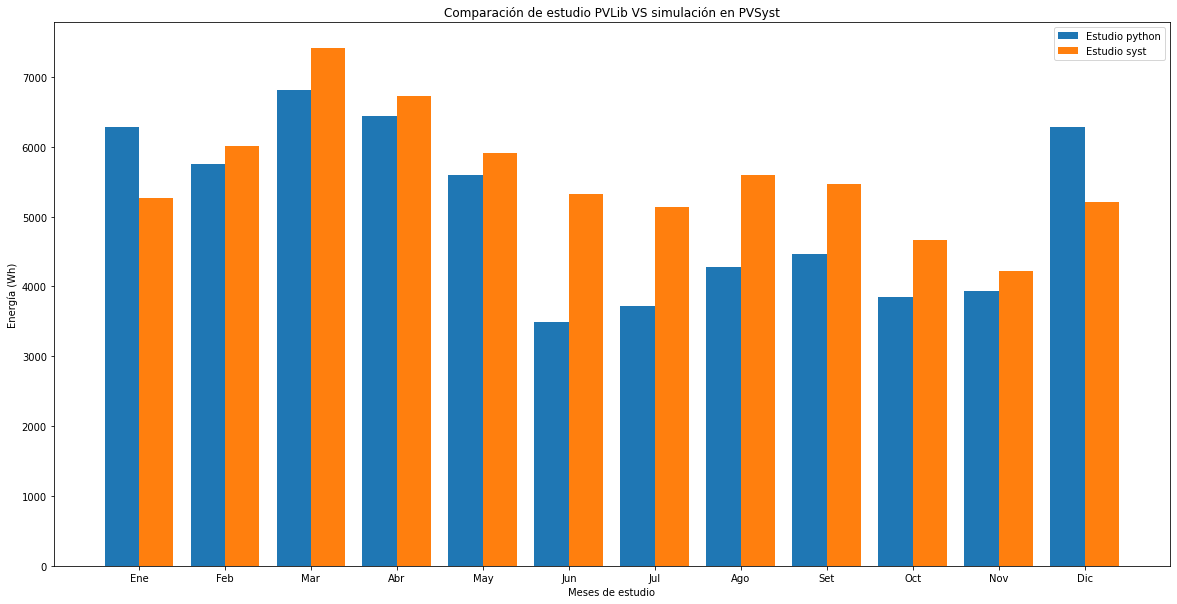

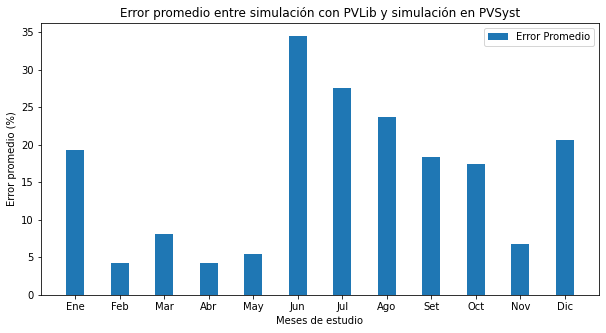

In [74]:
# Copiar los datos obtenidos de PVSyst en una lista para desplegarse,
#  en conjunto con los datos obtenidos de PVLib
reference_incident_energy_pvsyst = [4.790, 5.460, 6.740, 6.120, 5.380, 4.840, 4.670, 5.090, 4.970, 4.240, 3.840, 4.740]
energy_per_hour_pvsyst = []
for value in reference_incident_energy_pvsyst:
  energy_per_hour_pvsyst.append(value*1100) #1100 Wats porque son 5 paneles de 220 Wp

error_promedio = []
for index, value in enumerate(estudio_por_mes):
  error_promedio.append(np.mean(np.abs((energy_per_hour_pvsyst[index] - estudio_por_mes[index])/energy_per_hour_pvsyst[index]))*100)
error_promedio_values = list(error_promedio)

estudio_por_mes = {}
for i in selected_months:
  this_year = i['year']
  this_month = i['month']
  mes = str(this_year) + '-' + str(this_month) + '-01'
  x = selected_data.loc[mes:mes]
  sumatoria = x.sum()
  estudio_por_mes[mes[:-3]] = float(sumatoria)

labels = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Set', 'Oct', 'Nov', 'Dic']
potencia_maxima_del_panel = module['Impo'] * module['Vmpo'] * string_config

estudio_por_mes = pd.Series(estudio_por_mes)
estudio_por_mes_labels = list(estudio_por_mes.keys())
estudio_por_mes_values = list(estudio_por_mes)

#Crear una serie de Pandas basado en los datos obtenidos de PVSyst
energy_per_hour_pvsyst = pd.Series(energy_per_hour_pvsyst)
energy_per_hour_pvsyst_values = list(energy_per_hour_pvsyst)

X_axis = np.arange(len(labels))
plt.figure(figsize=(20,10))
plt.bar(X_axis - 0.2, estudio_por_mes_values, 0.4, label = 'Estudio python')
plt.bar(X_axis + 0.2, energy_per_hour_pvsyst_values, 0.4, label = 'Estudio syst')
plt.xticks(X_axis, labels)
plt.xlabel("Meses de estudio")
plt.ylabel("Energía (Wh)")
plt.title("Comparación de estudio PVLib VS simulación en PVSyst")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.bar(X_axis, error_promedio_values, 0.4, label = 'Error Promedio')
plt.xticks(X_axis, labels)
plt.xlabel("Meses de estudio")
plt.ylabel("Error promedio (%)")
plt.title("Error promedio entre simulación con PVLib y simulación en PVSyst")
plt.legend()
plt.show()